# 04 — Vol Surfaces

Explore volatility surfaces and 3D Greek surfaces for advanced sensitivity analysis.

This notebook demonstrates:
- Implied volatility surface (strike x expiration x IV)
- Delta and gamma surfaces (price x vol/time)
- Vanna/volga profiles for vol-of-vol risk
- Vol scenario analysis (P&L under different IV regimes)

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Setup

In [2]:
from options_analyzer.config import load_config
from options_analyzer.adapters.tastytrade.session import TastyTradeSession
from options_analyzer.adapters.tastytrade.market_data import TastyTradeMarketDataProvider

config = load_config()

tt_session = TastyTradeSession(config.provider)
await tt_session.connect()
market_data = TastyTradeMarketDataProvider(tt_session)
print(f"Connected to TastyTrade ({'paper' if config.provider.is_paper else 'live'}).")

Connected to TastyTrade (live).


## 2. Fetch IV Data

Build the implied volatility surface from live option chain data across multiple expirations.

We stream Greeks for near-ATM options to get real IVs, then assemble into a surface.

In [ ]:
import asyncio
from datetime import date, timedelta
from decimal import Decimal

import numpy as np

from options_analyzer.domain.enums import OptionType
from options_analyzer.adapters.tastytrade.streaming import DXLinkStreamerWrapper

UNDERLYING = "SPX"

chain = await market_data.get_option_chain(UNDERLYING)
spot_price = await market_data.get_underlying_price(UNDERLYING)
spot = float(spot_price)
print(f"{UNDERLYING} spot: ${spot:.2f}")

# Select first 5 expirations with enough strikes
sorted_exps = sorted(chain.keys())
selected_exps = [d for d in sorted_exps if d > date.today()][:5]

# Collect ALL near-ATM streamer symbols from all expirations into a flat list
all_symbols = []
symbol_to_strike_dte = {}  # {streamer_symbol: (strike, dte)}

for exp_date in selected_exps:
    contracts = chain[exp_date]
    calls = [c for c in contracts if c.option_type == OptionType.CALL]
    near_atm = [
        c for c in calls
        if abs(float(c.strike) - spot) <= 20
    ]
    if not near_atm:
        continue
    dte = (exp_date - date.today()).days
    for c in near_atm:
        if c.streamer_symbol:
            all_symbols.append(c.streamer_symbol)
            symbol_to_strike_dte[c.streamer_symbol] = (float(c.strike), dte)

# Stream Greeks with a single WebSocket connection + timeout
iv_data = {}  # {(strike, dte): iv}
streamer = DXLinkStreamerWrapper(tt_session)

if all_symbols:
    print(f"Subscribing to {len(all_symbols)} symbols across {len(selected_exps)} expirations...")
    tick_count = 0
    try:
        async with asyncio.timeout(30):
            async for event_symbol, greeks in streamer.subscribe_greeks(all_symbols):
                info = symbol_to_strike_dte.get(event_symbol)
                if info and greeks.iv > 0:
                    strike, dte = info
                    iv_data[(strike, dte)] = greeks.iv
                tick_count += 1
                if tick_count >= len(all_symbols) * 2:
                    break
    except TimeoutError:
        print(f"Stream timed out after 30s (collected {len(iv_data)} points from {tick_count} ticks)")
    except asyncio.CancelledError:
        pass

unique_dtes = len(set(dte for _, dte in iv_data.keys()))
unique_strikes = len(set(strike for strike, _ in iv_data.keys()))
print(f"Collected {len(iv_data)} IV data points: {unique_strikes} unique strikes, {unique_dtes} unique DTEs")

## 3. Implied Vol Surface

The IV surface reveals the vol smile/skew across strikes and the term structure across expirations.

In [ ]:
from options_analyzer.visualization.surface_charts import plot_greek_surface

if iv_data:
    # Build surface grid
    strikes = sorted(set(k[0] for k in iv_data))
    dtes = sorted(set(k[1] for k in iv_data))

    strike_arr = np.array(strikes)
    dte_arr = np.array(dtes)
    iv_surface = np.full((len(dtes), len(strikes)), np.nan)

    for (strike, dte), iv in iv_data.items():
        i = dtes.index(dte)
        j = strikes.index(strike)
        iv_surface[i, j] = iv * 100  # Display as percentage

    # Interpolate NaN gaps — choose method based on data spread
    from scipy.interpolate import griddata

    valid = ~np.isnan(iv_surface)
    valid_count = int(valid.sum())
    n_unique_dtes = len(dtes)
    n_unique_strikes = len(strikes)

    if valid_count > 3 and n_unique_dtes >= 2 and n_unique_strikes >= 2:
        # Sufficient 2D spread for Delaunay triangulation
        points = np.array([(dtes[i], strikes[j])
                           for i in range(len(dtes)) for j in range(len(strikes)) if valid[i, j]])
        values = np.array([iv_surface[i, j]
                           for i in range(len(dtes)) for j in range(len(strikes)) if valid[i, j]])
        grid_dte, grid_strike = np.meshgrid(dte_arr, strike_arr, indexing='ij')
        iv_surface = griddata(points, values, (grid_dte, grid_strike), method='linear')
        print(f"Interpolation: linear ({valid_count} points, {n_unique_dtes} DTEs, {n_unique_strikes} strikes)")
    elif valid_count >= 2:
        # Not enough 2D spread for linear — use nearest-neighbor (no triangulation)
        points = np.array([(dtes[i], strikes[j])
                           for i in range(len(dtes)) for j in range(len(strikes)) if valid[i, j]])
        values = np.array([iv_surface[i, j]
                           for i in range(len(dtes)) for j in range(len(strikes)) if valid[i, j]])
        grid_dte, grid_strike = np.meshgrid(dte_arr, strike_arr, indexing='ij')
        iv_surface = griddata(points, values, (grid_dte, grid_strike), method='nearest')
        print(f"Interpolation: nearest ({valid_count} points, {n_unique_dtes} DTEs, {n_unique_strikes} strikes)")
    else:
        # Too few points — plot raw data with NaN gaps (Plotly handles NaN gracefully)
        print(f"Interpolation: none ({valid_count} points — plotting raw data)")

    fig = plot_greek_surface(
        strike_arr, dte_arr, iv_surface,
        x_label="Strike Price",
        y_label="Days to Expiration",
        z_label="Implied Vol (%)",
        title=f"{UNDERLYING} — Implied Volatility Surface",
    )
    fig.show()
else:
    print("No IV data collected. Try running during market hours.")

## 4. Select a Position

Build a multi-leg position for Greek surface analysis.

In [5]:
from datetime import UTC, datetime

from options_analyzer.domain.models import Leg, Position
from options_analyzer.domain.enums import PositionSide

# Build a straddle for interesting surface shapes
exp_date = selected_exps[1] if len(selected_exps) > 1 else selected_exps[0]
all_contracts = chain[exp_date]

calls = {c.strike: c for c in all_contracts if c.option_type == OptionType.CALL}
puts = {c.strike: c for c in all_contracts if c.option_type == OptionType.PUT}

atm_strike = min(calls.keys(), key=lambda k: abs(float(k) - spot))

position = Position(
    id="straddle-1",
    name=f"{UNDERLYING} {atm_strike} Straddle",
    underlying=UNDERLYING,
    legs=[
        Leg(contract=calls[atm_strike], side=PositionSide.SHORT, quantity=1, open_price=Decimal("5.00")),
        Leg(contract=puts[atm_strike], side=PositionSide.SHORT, quantity=1, open_price=Decimal("5.00")),
    ],
    opened_at=datetime.now(tz=UTC),
)

# IVs for the position
ivs = {leg.contract.symbol: 0.20 for leg in position.legs}

print(f"Position: {position.name}")
print(f"Expiration: {exp_date} ({(exp_date - date.today()).days} DTE)")
for leg in position.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    print(f"  {side:>5} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}")

Position: SPX 6970.0 Straddle
Expiration: 2026-02-12 (2 DTE)
  SHORT 1x CALL 6970.0
  SHORT 1x PUT 6970.0


## 5. Delta Surface

Delta across the price x implied vol grid. Reveals how delta sensitivity changes with both price and volatility.

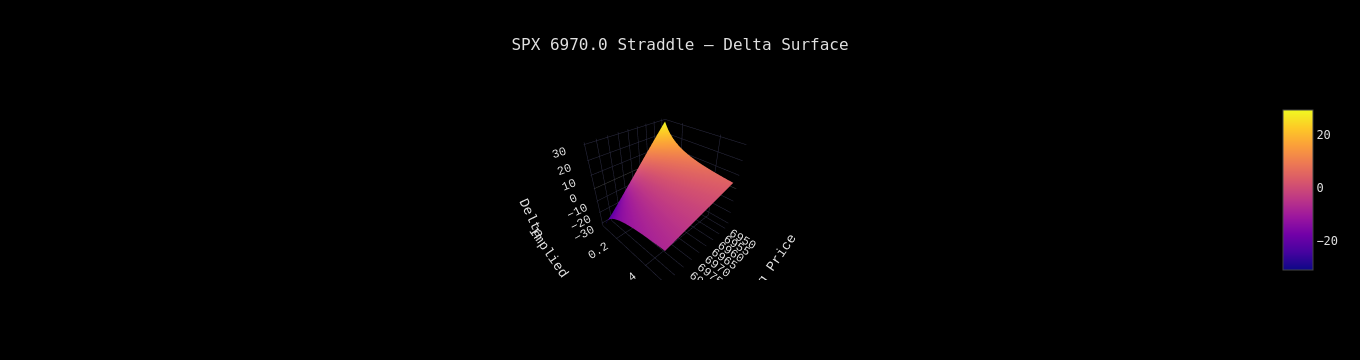

In [6]:
from options_analyzer.engine.greeks_calculator import GreeksCalculator
from options_analyzer.engine.position_analyzer import PositionAnalyzer
from options_analyzer.visualization.surface_charts import plot_delta_surface

greeks_calc = GreeksCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)
analyzer = PositionAnalyzer(greeks_calc)

price_range = np.linspace(spot - 20, spot + 20, 50)
vol_range = np.linspace(0.10, 0.50, 30)

# Compute delta for each (price, vol) point
delta_surface = np.zeros((len(vol_range), len(price_range)))
dte = (exp_date - date.today()).days
T = max(dte / 365.0, 0.001)

for i, vol in enumerate(vol_range):
    vol_ivs = {leg.contract.symbol: vol for leg in position.legs}
    for j, S in enumerate(price_range):
        pg = analyzer.position_greeks(position, float(S), vol_ivs)
        delta_surface[i, j] = pg.aggregated.first_order.delta

fig = plot_delta_surface(
    price_range, vol_range, delta_surface,
    title=f"{position.name} — Delta Surface",
)
fig.show()

## 6. Gamma Surface

Gamma across price x time — reveals how gamma concentrates near ATM as expiration approaches.

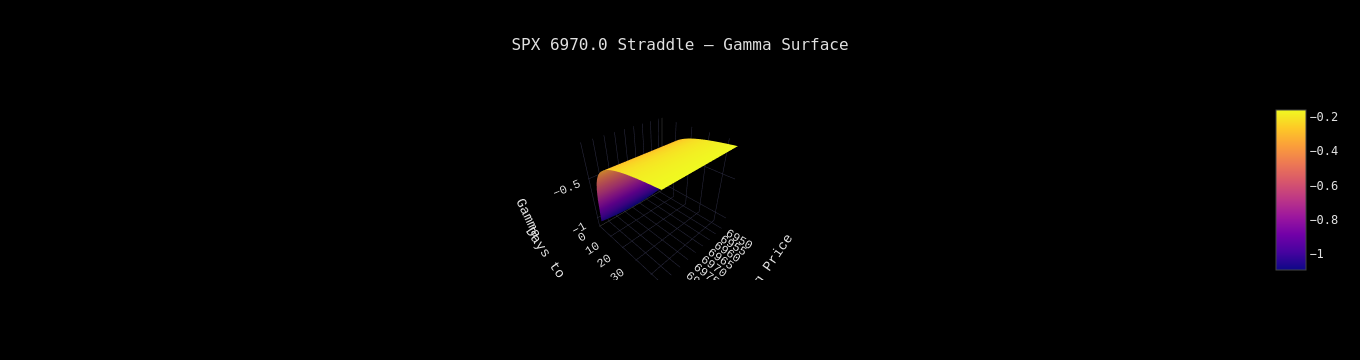

In [7]:
from options_analyzer.visualization.surface_charts import plot_gamma_surface

dte_range = np.linspace(1, 45, 40)

surfaces = analyzer.greeks_surface(position, price_range, ivs, dte_range)

fig = plot_gamma_surface(
    price_range, dte_range, surfaces["gamma"],
    title=f"{position.name} — Gamma Surface",
)
fig.show()

## 7. Vanna/Volga Analysis

These second-order Greeks measure vol-of-vol risk:

- **Vanna**: How delta changes when IV moves — crucial for vol-exposed positions
- **Volga**: Convexity of vega — determines if you benefit from vol-of-vol

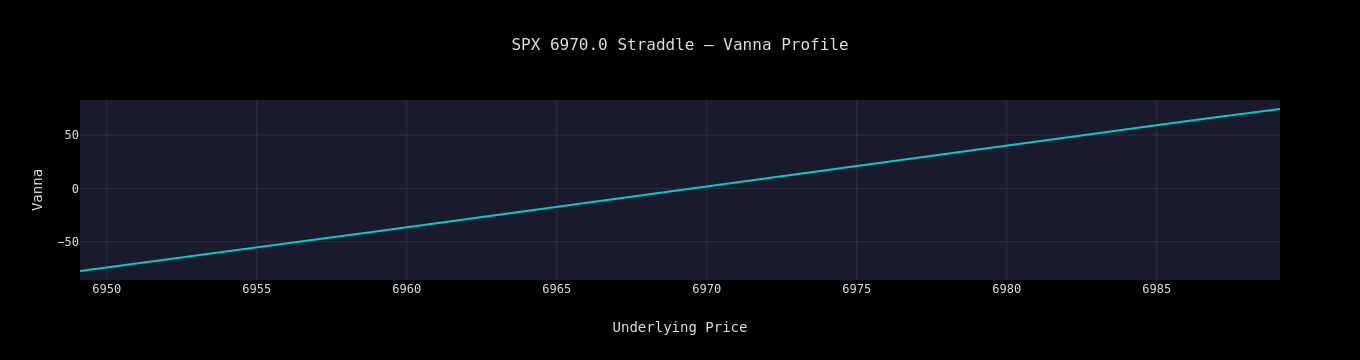

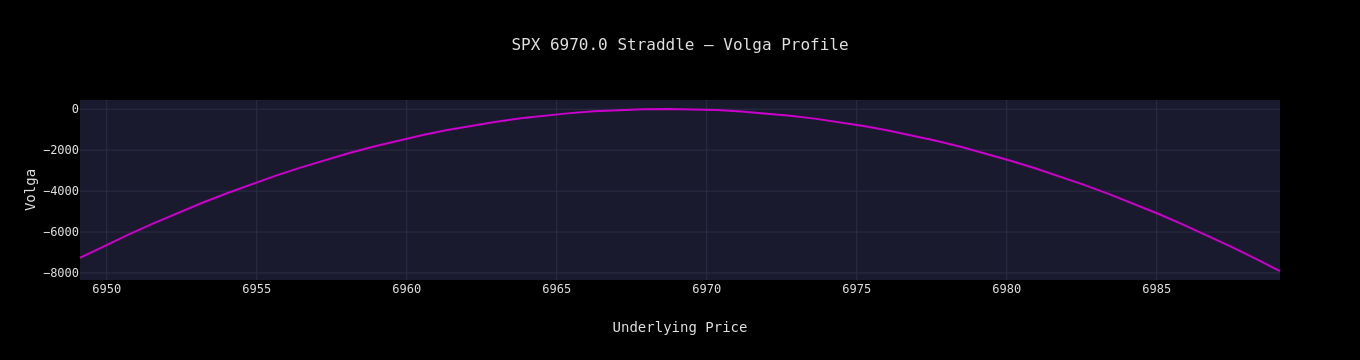

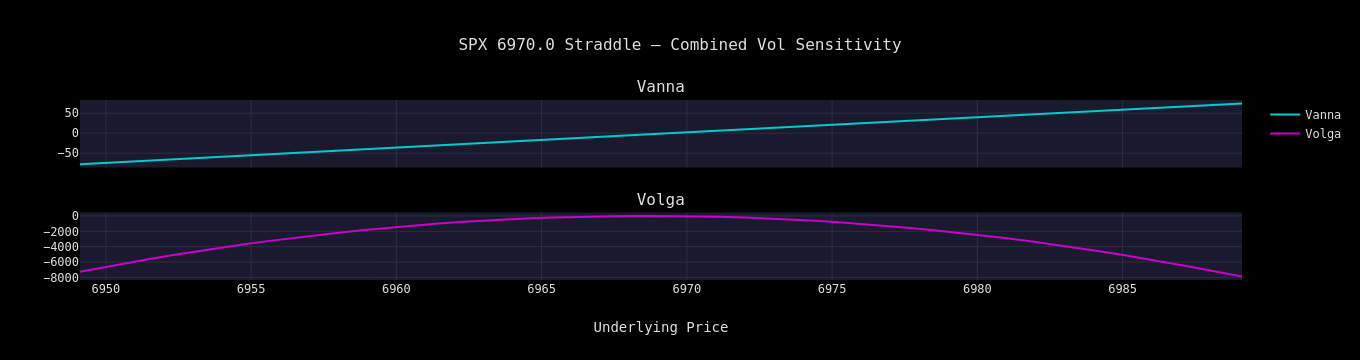

In [8]:
from options_analyzer.visualization.vol_charts import (
    plot_vanna_profile,
    plot_volga_profile,
    plot_vol_sensitivity,
)

greeks_profile = analyzer.greeks_vs_price(position, price_range, ivs)

fig = plot_vanna_profile(
    price_range, greeks_profile["vanna"],
    title=f"{position.name} — Vanna Profile",
)
fig.show()

fig = plot_volga_profile(
    price_range, greeks_profile["volga"],
    title=f"{position.name} — Volga Profile",
)
fig.show()

fig = plot_vol_sensitivity(
    price_range,
    {"vanna": greeks_profile["vanna"], "volga": greeks_profile["volga"]},
    title=f"{position.name} — Combined Vol Sensitivity",
)
fig.show()

## 8. Vol Scenario Analysis

How does the P&L change under different IV scenarios? This is essential for risk management — understanding your exposure to vol moves.

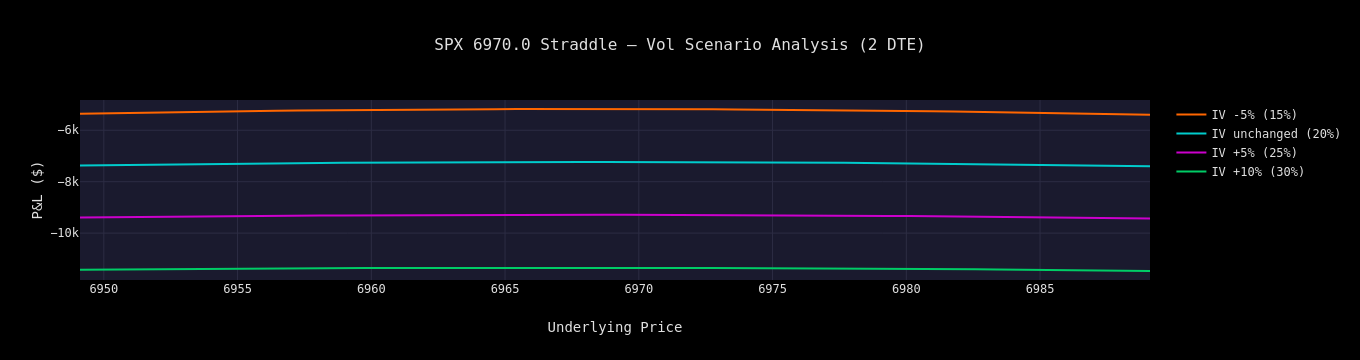


P&L at current spot ($6970):
  IV -5% (15%)             : $-5174.48
  IV unchanged (20%)       : $-7232.39
  IV +5% (25%)             : $-9290.30
  IV +10% (30%)            : $-11348.20


In [9]:
from options_analyzer.engine.payoff import PayoffCalculator
from options_analyzer.visualization.payoff_charts import plot_theoretical_pnl

payoff_calc = PayoffCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)

base_iv = 0.20
scenarios = {
    "IV -5% (15%)": {leg.contract.symbol: base_iv - 0.05 for leg in position.legs},
    "IV unchanged (20%)": {leg.contract.symbol: base_iv for leg in position.legs},
    "IV +5% (25%)": {leg.contract.symbol: base_iv + 0.05 for leg in position.legs},
    "IV +10% (30%)": {leg.contract.symbol: base_iv + 0.10 for leg in position.legs},
}

current_dte = float(dte)
pnl_by_scenario = {}
for label, scenario_ivs in scenarios.items():
    pnl_by_scenario[label] = payoff_calc.theoretical_pnl(
        position, price_range, scenario_ivs, current_dte,
    )

fig = plot_theoretical_pnl(
    price_range, pnl_by_scenario,
    title=f"{position.name} — Vol Scenario Analysis ({int(current_dte)} DTE)",
)
fig.show()

# Report best/worst scenarios at current spot
center_idx = len(price_range) // 2
print(f"\nP&L at current spot (${price_range[center_idx]:.0f}):")
for label, pnl in pnl_by_scenario.items():
    print(f"  {label:<25s}: ${pnl[center_idx]:>8.2f}")

## 9. Cleanup

In [10]:
await tt_session.disconnect()
print("Session disconnected.")

Session disconnected.
